In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [2]:
df_Test_Train = pd.read_csv('Fastai_dataset_usable.csv')
df_Test_Train.drop(df_Test_Train.columns[df_Test_Train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

df_Test_Train.head(100)

Crp_Filepath  clutch  Day  egg_number  \
0       Cropped_Egg_images/Clutch1_D18/egg2.JPG       1   18           2   
1       Cropped_Egg_images/Clutch1_D18/egg3.JPG       1   18           3   
2       Cropped_Egg_images/Clutch1_D18/egg4.JPG       1   18           4   
3       Cropped_Egg_images/Clutch1_D18/egg6.JPG       1   18           6   
4       Cropped_Egg_images/Clutch1_D18/egg9.JPG       1   18           9   
5      Cropped_Egg_images/Clutch1_D18/egg11.JPG       1   18          11   
6      Cropped_Egg_images/Clutch1_D18/egg15.JPG       1   18          15   
7      Cropped_Egg_images/Clutch1_D18/egg16.JPG       1   18          16   
8      Cropped_Egg_images/Clutch1_D18/egg17.JPG       1   18          17   
9      Cropped_Egg_images/Clutch1_D18/egg19.JPG       1   18          19   
10     Cropped_Egg_images/Clutch1_D18/egg20.JPG       1   18          20   
11     Cropped_Egg_images/Clutch1_D18/egg21.JPG       1   18          21   
12     Cropped_Egg_images/Clutch1_D18/egg22.JPG       1   18          22   
13     Cropped_Egg_images/Clutch1_D18/egg23.JPG       1   18          23   
14     Cropped_Egg_images/Clutch1_D18/egg26.JPG       1   18          26   
15     Cropped_Egg_images/Clutch1_D18/egg28.JPG       1   18          28   
16     Cropped_Egg_images/Clutch1_D18/egg29.JPG       1   18          29   
17     Cropped_Egg_images/Clutch1_D18/egg31.JPG       1   18          31   
18     Cropped_Egg_images/Clutch1_D18/egg33.JPG       1   18          33   
19     Cropped_Egg_images/Clutch1_D18/egg34.JPG       1   18          34   
20     Cropped_Egg_images/Clutch1_D18/egg35.JPG       1   18          35   
21     Cropped_Egg_images/Clutch1_D18/egg36.JPG       1   18          36   
22     Cropped_Egg_images/Clutch1_D18/egg37.JPG       1   18          37   
23     Cropped_Egg_images/Clutch1_D18/egg38.JPG       1   18          38   
24     Cropped_Egg_images/Clutch1_D18/egg39.JPG       1   18          39   
25     Cropped_Egg_images/Clutch1_D18/egg40.JPG       1   18          40   
26     Cropped_Egg_images/Clutch1_D18/egg41.JPG       1   18          41   
27     Cropped_Egg_images/Clutch1_D18/egg42.JPG       1   18          42   
28     Cropped_Egg_images/Clutch1_D18/egg45.JPG       1   18          45   
29     Cropped_Egg_images/Clutch1_D18/egg46.JPG       1   18          46   
..                                          ...     ...  ...         ...   
64  Cropped_Egg_images/Clutch2_D18/IMG_0022.JPG       2   18          21   
65  Cropped_Egg_images/Clutch2_D18/IMG_0025.JPG       2   18          24   
66  Cropped_Egg_images/Clutch2_D18/IMG_0027.JPG       2   18          26   
67  Cropped_Egg_images/Clutch2_D18/IMG_0028.JPG       2   18          27   
68  Cropped_Egg_images/Clutch2_D18/IMG_0029.JPG       2   18          28   
69  Cropped_Egg_images/Clutch2_D18/IMG_0030.JPG       2   18          29   
70  Cropped_Egg_images/Clutch2_D18/IMG_0033.JPG       2   18          32   
71  Cropped_Egg_images/Clutch2_D18/IMG_0034.JPG       2   18          33   
72  Cropped_Egg_images/Clutch2_D18/IMG_0035.JPG       2   18          34   
73  Cropped_Egg_images/Clutch2_D18/IMG_0036.JPG       2   18          35   
74  Cropped_Egg_images/Clutch2_D18/IMG_0037.JPG       2   18          36   
75  Cropped_Egg_images/Clutch2_D18/IMG_0038.JPG       2   18          37   
76  Cropped_Egg_images/Clutch2_D18/IMG_0039.JPG       2   18          38   
77  Cropped_Egg_images/Clutch2_D18/IMG_0040.JPG       2   18          39   
78  Cropped_Egg_images/Clutch2_D18/IMG_0042.JPG       2   18          41   
79  Cropped_Egg_images/Clutch2_D18/IMG_0043.JPG       2   18          42   
80  Cropped_Egg_images/Clutch2_D18/IMG_0046.JPG       2   18          45   
81  Cropped_Egg_images/Clutch2_D18/IMG_0047.JPG       2   18          46   
82  Cropped_Egg_images/Clutch2_D18/IMG_0050.JPG       2   18          49   
83  Cropped_Egg_images/Clutch2_D18/IMG_0052.JPG       2   18          51   
84  Cropped_Egg_images/Clutch2_D18/IMG_0053.JPG       2   18          52   
85  Cro

In [3]:
from sklearn.metrics import roc_auc_score

def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn,extra=None, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            return add_metrics(last_metrics, [metric])


# Continued testing on previous best results
[previous tests](initial_testing.ipynb)

## Repeated Stratified K-Fold tests
* Resnet18
* No Transforms
* wd = 0.01
* 9 epochs
* normalization off
* max lr not set

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


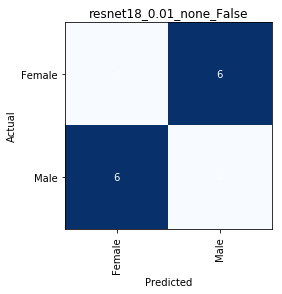

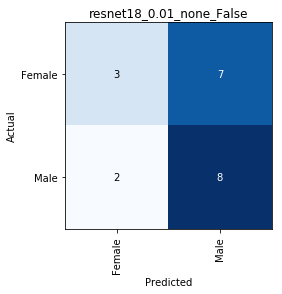

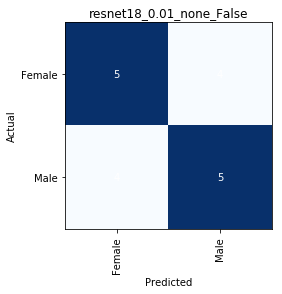

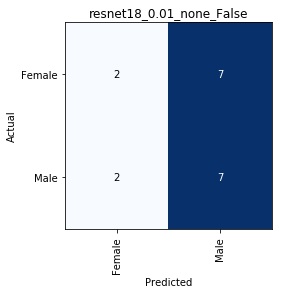

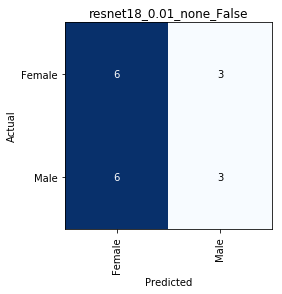

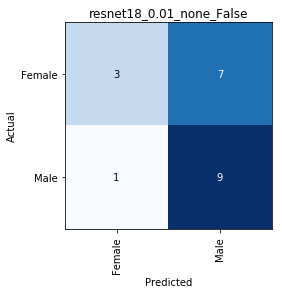

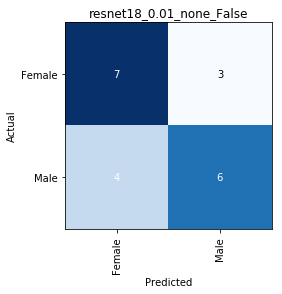

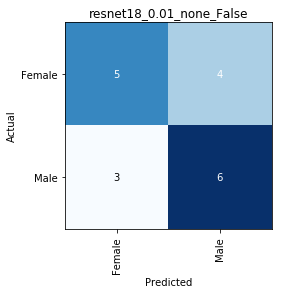

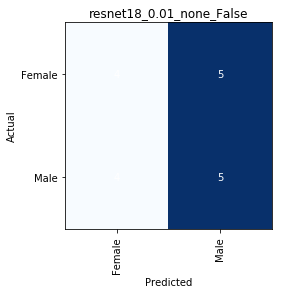

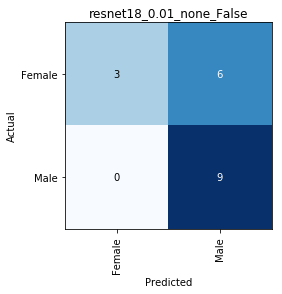

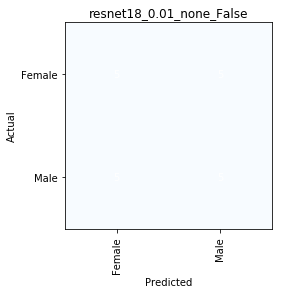

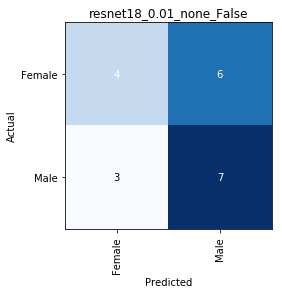

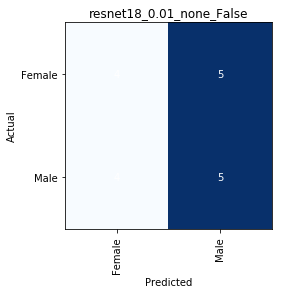

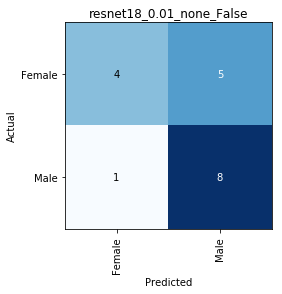

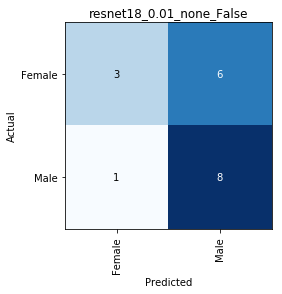

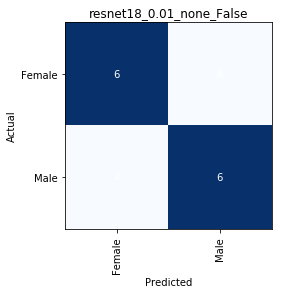

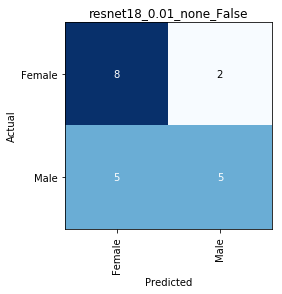

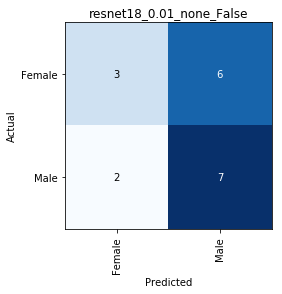

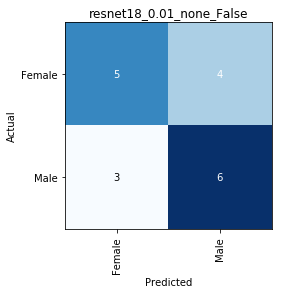

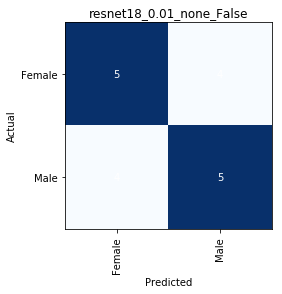

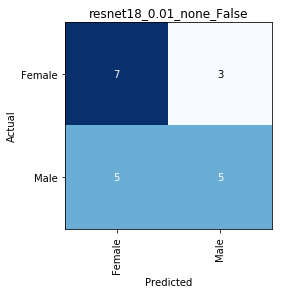

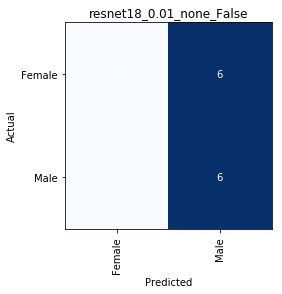

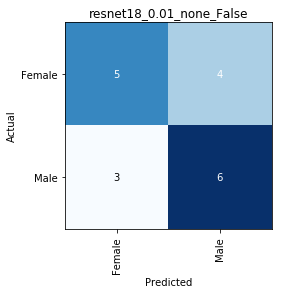

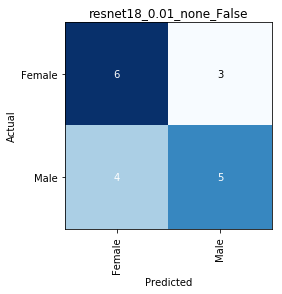

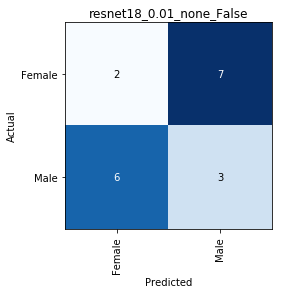

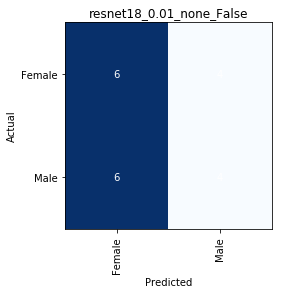

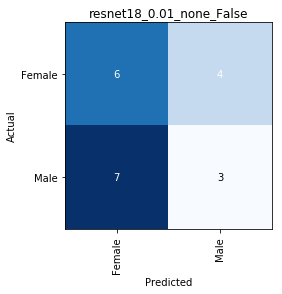

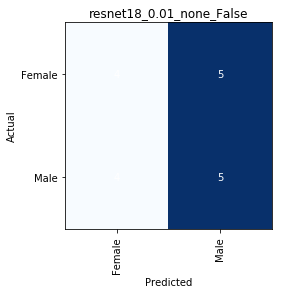

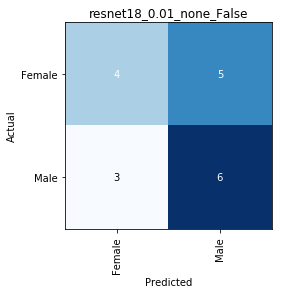

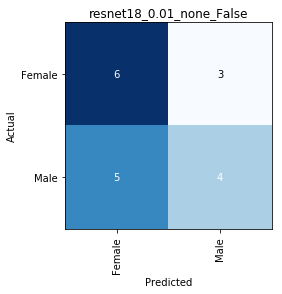

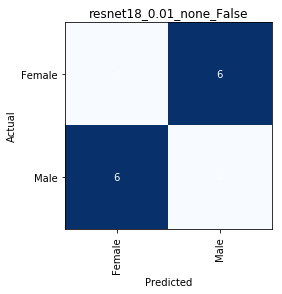

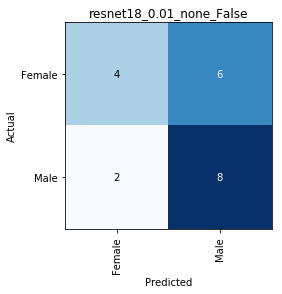

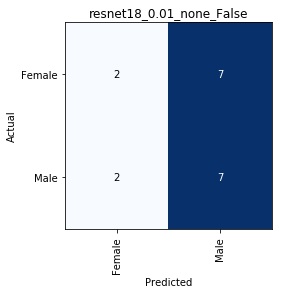

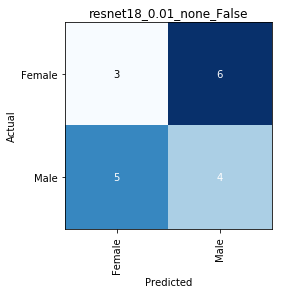

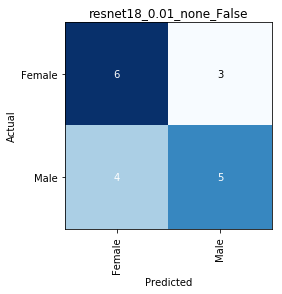

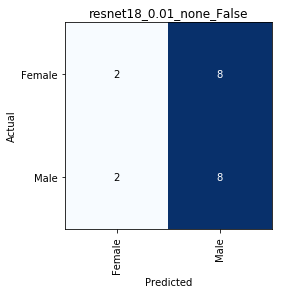

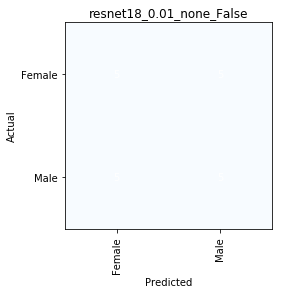

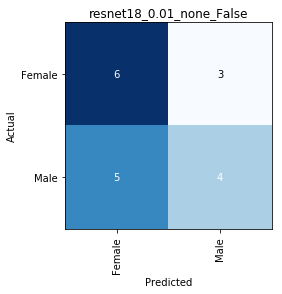

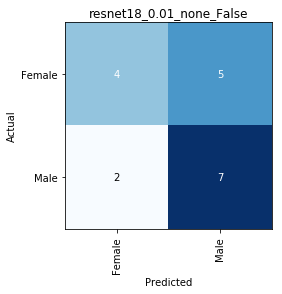

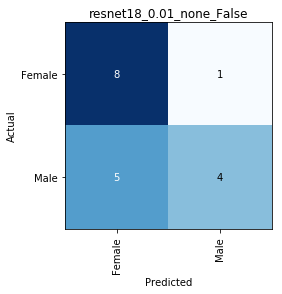

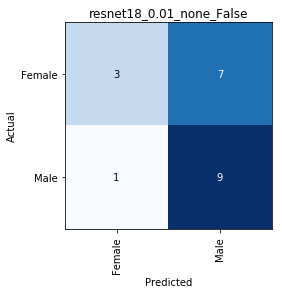

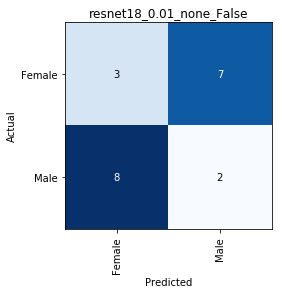

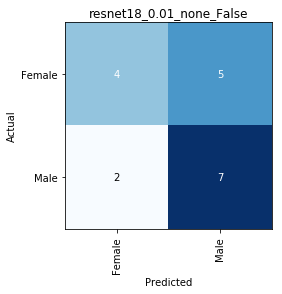

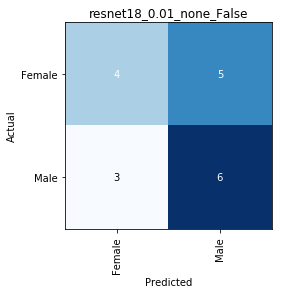

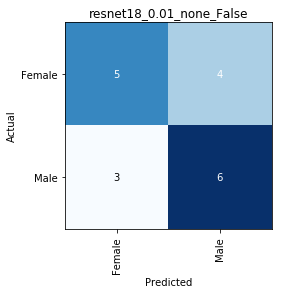

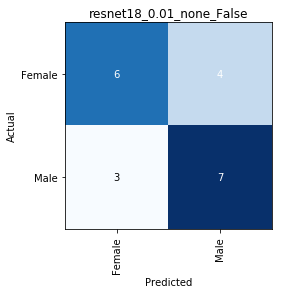

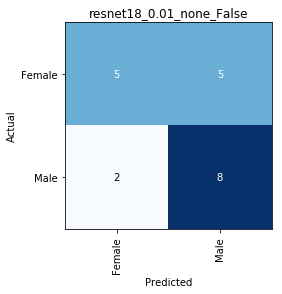

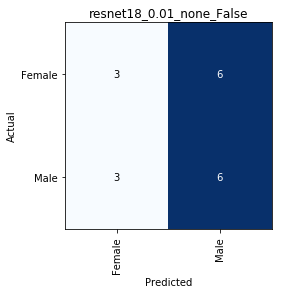

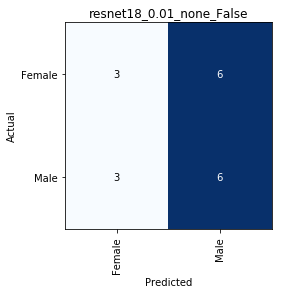

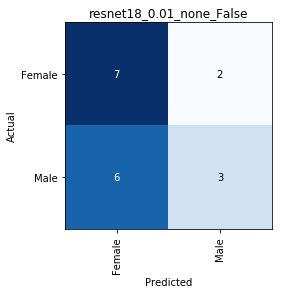

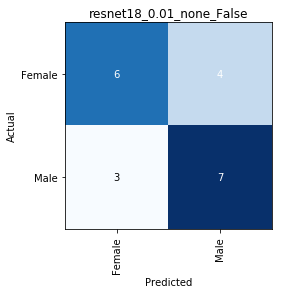

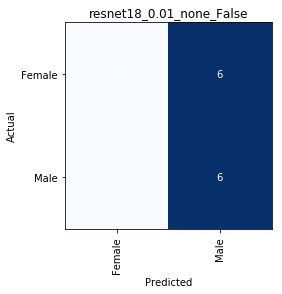

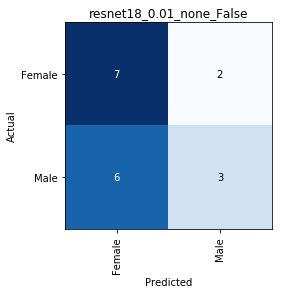

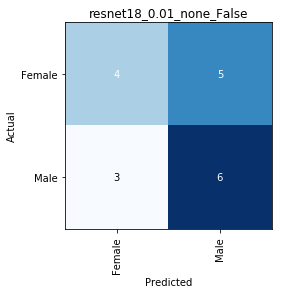

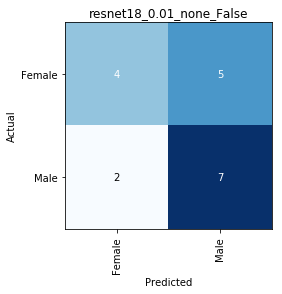

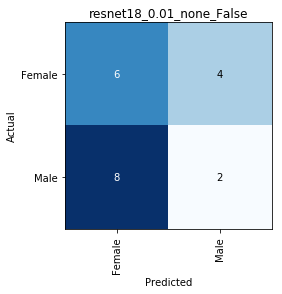

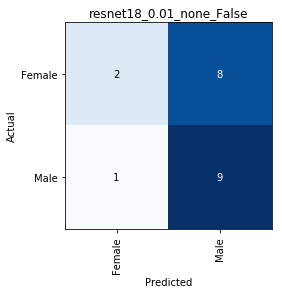

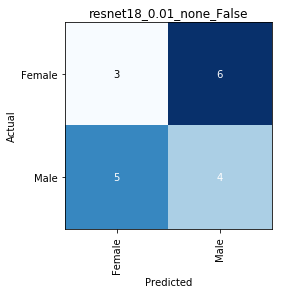

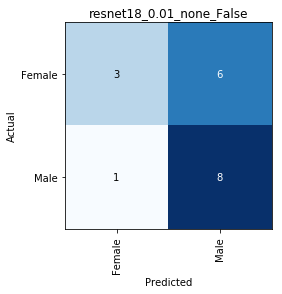

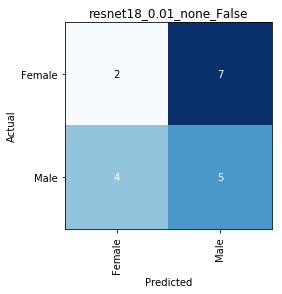

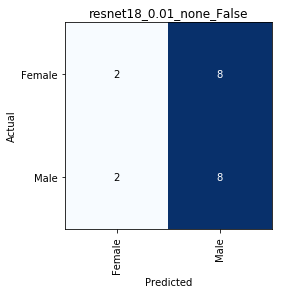

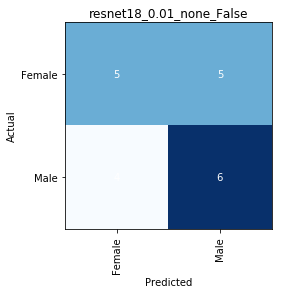

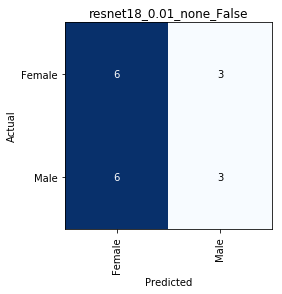

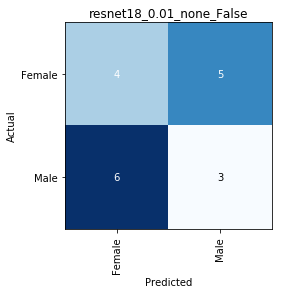

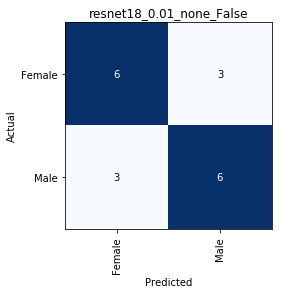

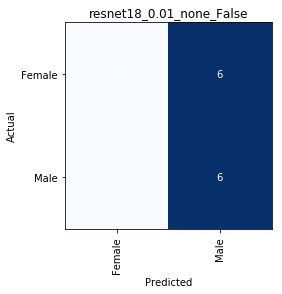

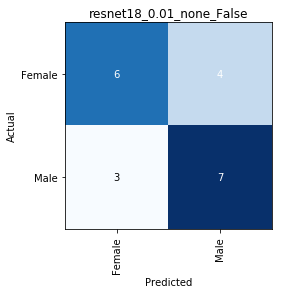

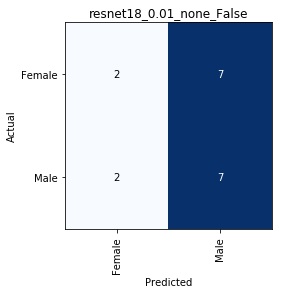

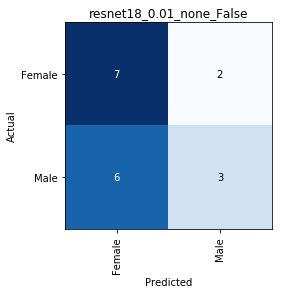

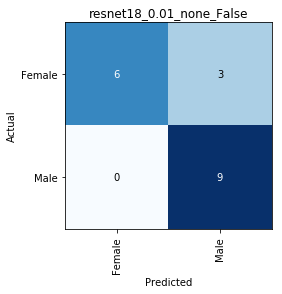

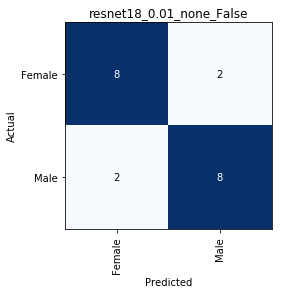

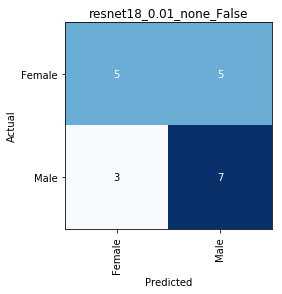

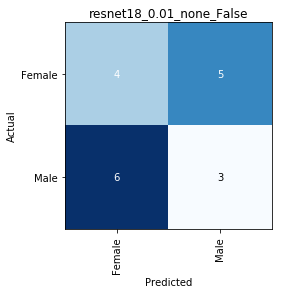

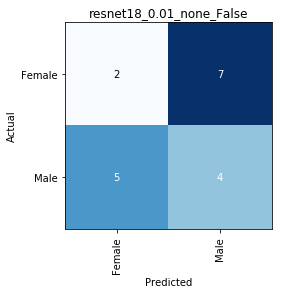

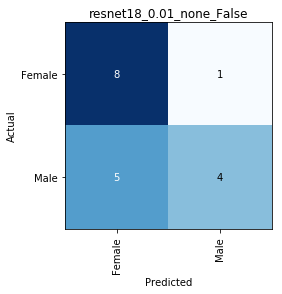

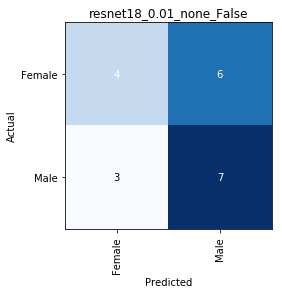

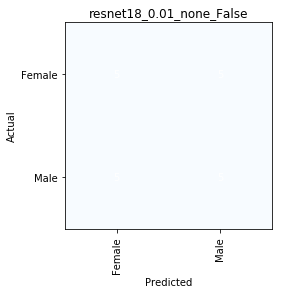

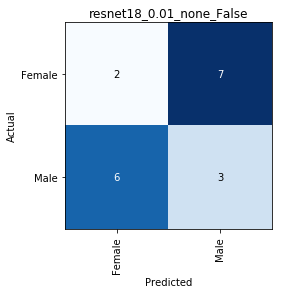

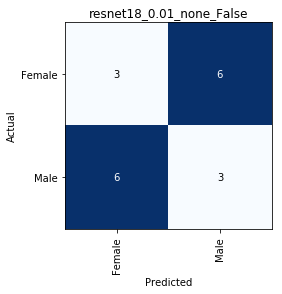

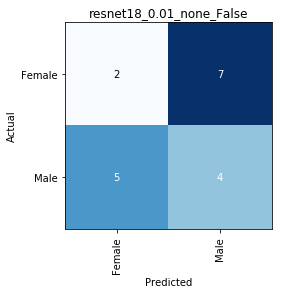

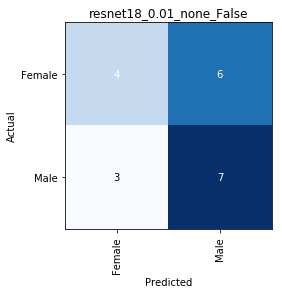

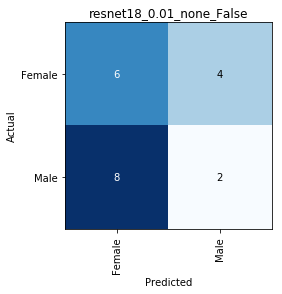

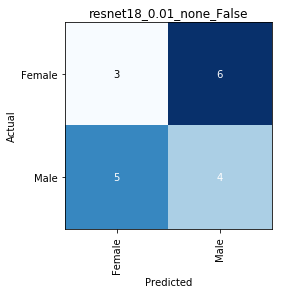

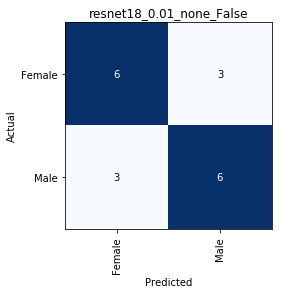

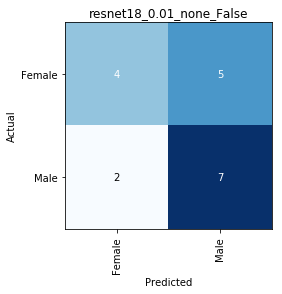

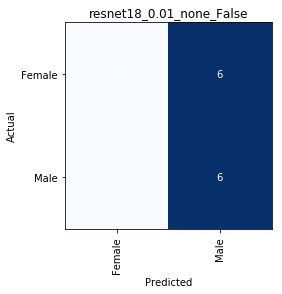

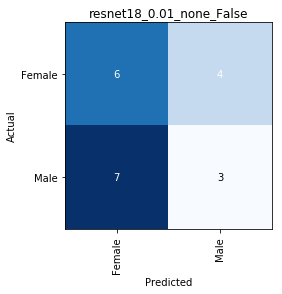

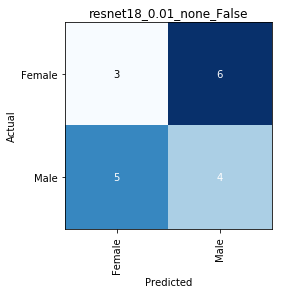

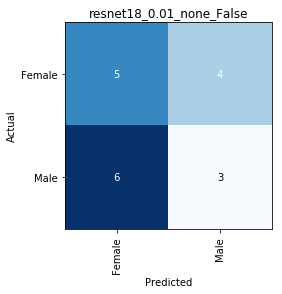

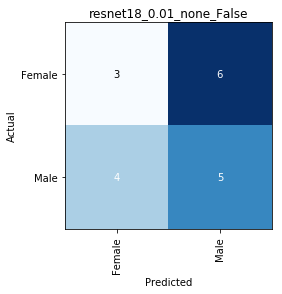

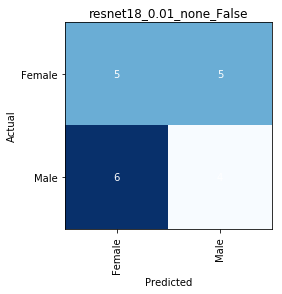

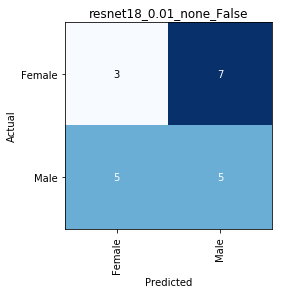

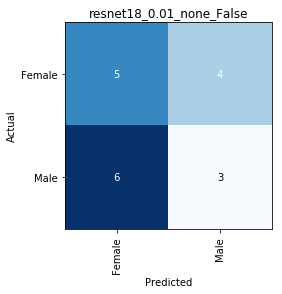

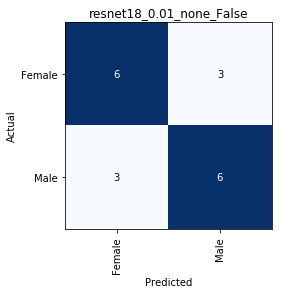

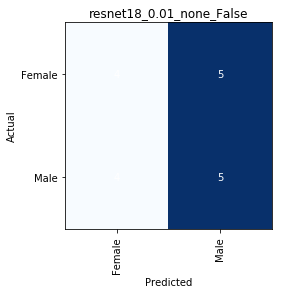

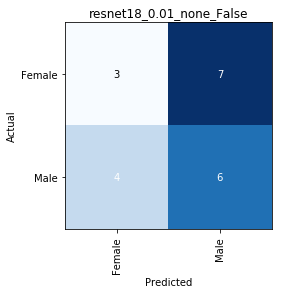

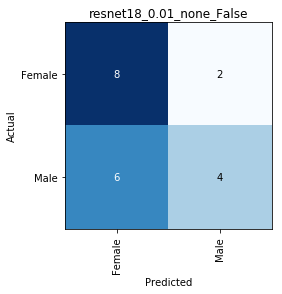

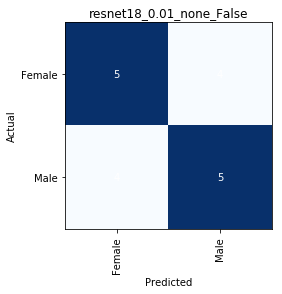

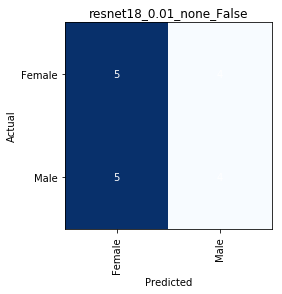

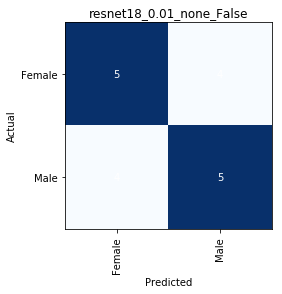

In [8]:
'''
Results from this test found that 42.8% of the 35 models had an AUROC >=.5
The Std of the AUROCS was .142529 with a mean AUROC of .503

'''

# Parameters to very
epoch_cycles=9
np.random.seed(42)

# Tests to Perform
tests = [[models.resnet18 , .01, None, False]]

# Creating Frame Work
DFBig = pd.DataFrame(columns = ['test_name','model_arch', 'transforms', 'normalized',
                                'weight_decay', 'split_num', 'train_df'])
# Creating Stratified K folds
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=6)

# For loop for test

for x in tests:
    wd = x[1]
    norm = x[3]
    arch = x[0]
    archstr = str(arch).split(' ')[1]
    if x[2] is not None:
        tsfmstr = 'modified'
    else:
        tsfmstr = 'none'
    test_name = archstr + '_' + str(wd) + '_' + tsfmstr + '_' + str(x[3])
    split_num = 1
    for train_index, val_index in rskf.split(df_Test_Train.index, df_Test_Train.sex):
        print(test_name)
        if norm:
            data_fold = (ImageList.from_df(df_Test_Train,'/home/jplineb/Chicken_Proj')
                         .split_by_idxs(train_index, val_index)
                         .label_from_df(cols='sex')
                         .transform(x[2], size=224)
                         .databunch(bs = 2)).normalize()
        else:
            data_fold = (ImageList.from_df(df_Test_Train,'/home/jplineb/Chicken_Proj')
                         .split_by_idxs(train_index, val_index)
                         .label_from_df(cols='sex')
                         .transform(x[2], size=224)
                         .databunch(bs = 2))
            
        learn = cnn_learner(data_fold, arch, metrics=error_rate, pretrained=True,callback_fns = [CSVLogger,AUROC, partial(EarlyStoppingCallback, monitor='AUROC', mode='max', min_delta=0.01, patience=100)], wd=wd)
        learn.fit_one_cycle(epoch_cycles)
        
        df_history = pd.read_csv('history.csv') # Appends to dataframe
        lowesterror = df_history.error_rate.idxmin()
        DFBig = DFBig.append({'test_name': test_name,
                              'model_arch': archstr,
                              'transforms': tsfmstr,
                              'normalized': str(norm),
                              'weight_decay': wd,
                              'split_num': split_num, # indicates kfold split
                              'error_rate_8' : df_history.error_rate[7],
                              'error_rate_9' : df_history.error_rate[8],
                              'AUROC_8': df_history.AUROC[7],
                              'AUROC_9': df_history.AUROC[8],
                              'train_df': df_history}, ignore_index = True)
        
        interp = ClassificationInterpretation.from_learner(learn)
        interp.plot_confusion_matrix(return_fig=True, title=test_name)
        split_num += 1
        DFBig.to_csv('DF_resnet18_01_epoch9.csv')

Results from the test:
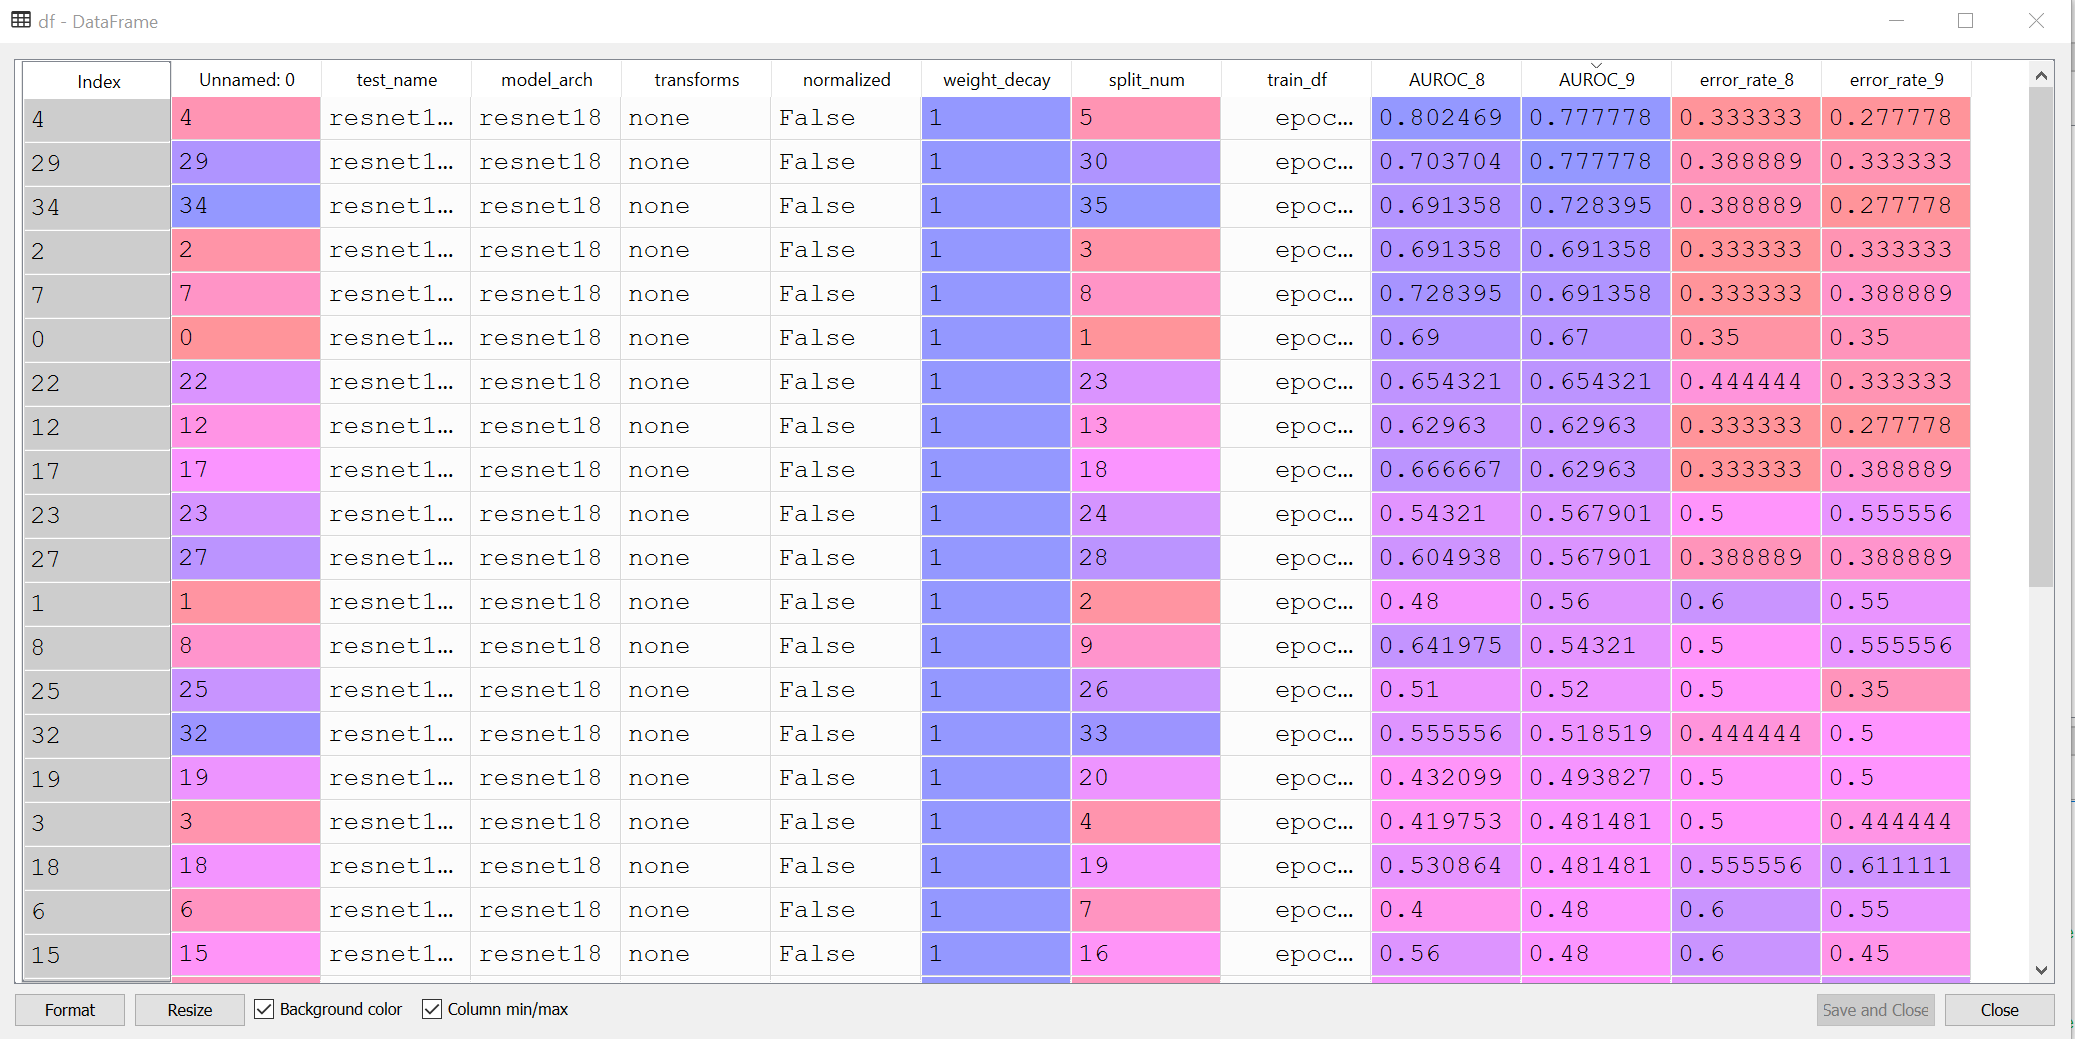

## max_lr Investigation

In [59]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate, wd=0.5, pretrained=True,
                   callback_fns=[AUROC, partial(EarlyStoppingCallback, monitor='AUROC', mode='max', min_delta=0.01, patience=100)])

(0, 4)

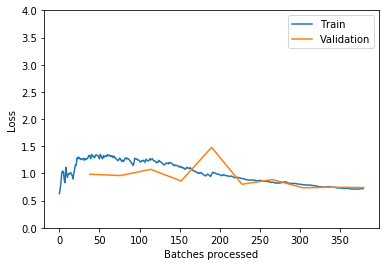

In [69]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate, wd=0.5, pretrained=True,
                   callback_fns=[AUROC, partial(EarlyStoppingCallback, monitor='AUROC', mode='max', min_delta=0.01, patience=100)])
learn.fit_one_cycle(10, max_lr=0.03)
learn.recorder.plot_losses()
plt.ylim(0,4)

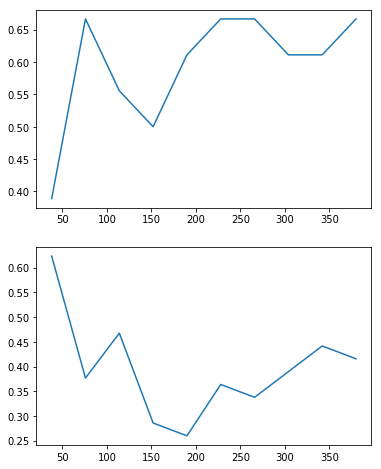

In [70]:
learn.recorder.plot_metrics()

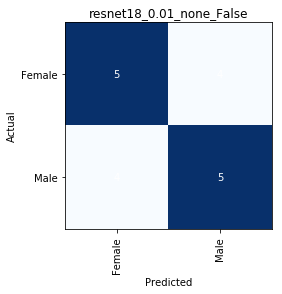

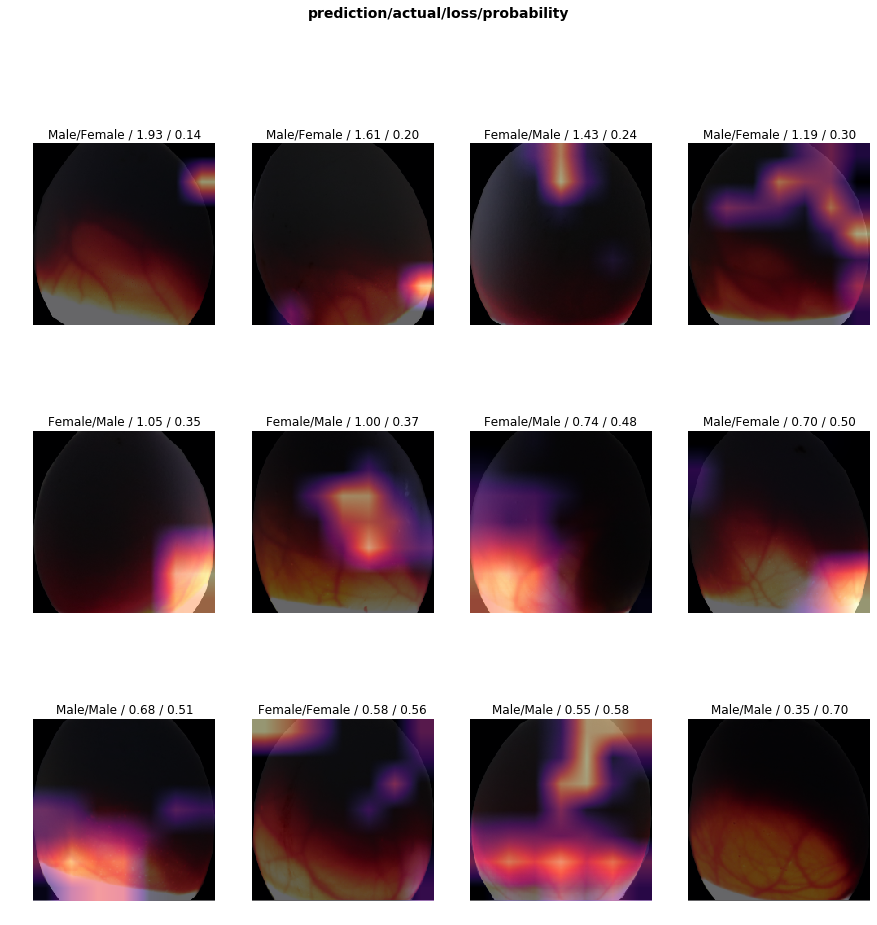

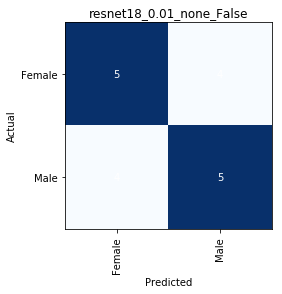

In [28]:
interp.plot_top_losses(12, figsize=(15,15))
interp.plot_confusion_matrix(return_fig=True, title=test_name)

# New hyperparameter search

Transforms: 
* resize (size=224)
* rotate (random +/- 15 deg)
* zoom (random scale from 0.85 to 1.15)
* flip (p=0.5)

Normalization: true

Search parameters:

In [83]:
max_lr = [0.01, 0.03, 0.1, 0.3]
wd = [0.01, 0.03, 0.1, 0.3, 1]
epoch = [5,7,9]
k =5
secs_per_epoch=2

In [84]:
# estimated time
np.sum([secs_per_epoch*e*len(max_lr)*len(wd) for e in epoch]) *k / 60

70.0

In [4]:
'''From this test we found that:

* Resnet18
* 7 Epochs
* learning rate of 0.1
* weight decay of 1

and

* Resnet18
* 7 Epochs
* weight decay of 1
* learning rate of 0.3

returned the best results
'''

max_lr = [0.01, 0.03, 0.1, 0.3]
weight_decay = [0.01, 0.03, 0.1, 0.3, 1]
epoch_cycles = [5,7,9]
k=5
secs_per_epoch=2

transforms=[[RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
           RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15.0, 15.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
           RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (0.85, 1.15), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.5, resolved={}, do_run=True, is_random=True)],
            []]

# Creating Frame Work
DFBig = pd.DataFrame(columns = ['test_name','model_arch', 'transforms', 'normalized',
                                'weight_decay', 'split_num'])
np.random.seed(42) #locks random seed
skf = StratifiedKFold(n_splits=5)
for wd in weight_decay:
    archstr = "resnet18"
    for epochs in epoch_cycles:    
        for lr in max_lr:
            test_name = archstr + '_' + str(epochs) + '_' + str(wd) + '_' + str(lr) + '_' + str('modified') + '_' + str('True')
            print(test_name)
            split_num = 1
            for train_index, val_index in skf.split(df_Test_Train.index, df_Test_Train['sex']):
                print(str(split_num))
                data_fold = (ImageList.from_df(df_Test_Train,'/home/jplineb/Chicken_Proj')
                             .split_by_idxs(train_index, val_index)
                             .label_from_df(cols='sex')
                             .transform(transforms, size=224)
                             .databunch(bs=2)).normalize()

                learn = cnn_learner(data_fold, models.resnet18, metrics=error_rate,
                                    callback_fns = [CSVLogger,AUROC, partial(EarlyStoppingCallback, monitor='AUROC', mode='max', min_delta=0.01, patience=100)], wd=wd)
                learn.fit_one_cycle(epochs, max_lr=lr)

                df_history = pd.read_csv('history.csv') # adds to dataframec created earlier (again norm and tsfms locked to ON)
                DFBig = DFBig.append({'test_name': test_name,
                                    'model_arch': 'resnet18',
                                    'transforms': 'modified',
                                    'normalized': 'true',
                                    'weight_decay': wd,
                                    'lr' :lr,
                                    'epoch': epochs,
                                    'split_num': split_num, # indicates kfold split
                                    'error_rate' : df_history.error_rate[epochs-1],
                                    'AUROC': df_history.AUROC[epochs-1],
                                    'train_df': df_history}, ignore_index = True)

                split_num+=1
                DFBig.to_csv('DF_new_hyperparameters.csv')

resnet18_5_0.01_0.01_modified_True
1


2


3


4


5


resnet18_5_0.01_0.03_modified_True
1


2


3


4


5


resnet18_5_0.01_0.1_modified_True
1


2


3


4


5


resnet18_5_0.01_0.3_modified_True
1


2


3


4


5


resnet18_7_0.01_0.01_modified_True
1


2


3


4


5


resnet18_7_0.01_0.03_modified_True
1


2


3


4


5


resnet18_7_0.01_0.1_modified_True
1


2


3


4


5


resnet18_7_0.01_0.3_modified_True
1


2


3


4


5


resnet18_9_0.01_0.01_modified_True
1


2


3


4


5


resnet18_9_0.01_0.03_modified_True
1


2


3


4


5


resnet18_9_0.01_0.1_modified_True
1


2


3


4


5


resnet18_9_0.01_0.3_modified_True
1


2


3


4


5


resnet18_5_0.03_0.01_modified_True
1


2


3


4


5


resnet18_5_0.03_0.03_modified_True
1


2


3


4


5


resnet18_5_0.03_0.1_modified_True
1


2


3


4


5


resnet18_5_0.03_0.3_modified_True
1


2


3


4


5


resnet18_7_0.03_0.01_modified_True
1


2


3


4


5


resnet18_7_0.03_0.03_modified_True
1


2


3


4


5


resnet18_7_0.03_0.1_modified_True
1


2


3


4


5


resnet18_7_0.03_0.3_modified_True
1


2


3


4


5


resnet18_9_0.03_0.01_modified_True
1


2


3


4


5


resnet18_9_0.03_0.03_modified_True
1


2


3


4


5


resnet18_9_0.03_0.1_modified_True
1


2


3


4


5


resnet18_9_0.03_0.3_modified_True
1


2


3


4


5


resnet18_5_0.1_0.01_modified_True
1


2


3


4


5


resnet18_5_0.1_0.03_modified_True
1


2


3


4


5


resnet18_5_0.1_0.1_modified_True
1


2


3


4


5


resnet18_5_0.1_0.3_modified_True
1


2


3


4


5


resnet18_7_0.1_0.01_modified_True
1


2


3


4


5


resnet18_7_0.1_0.03_modified_True
1


2


3


4


5


resnet18_7_0.1_0.1_modified_True
1


2


3


4


5


resnet18_7_0.1_0.3_modified_True
1


2


3


4


5


resnet18_9_0.1_0.01_modified_True
1


2


3


4


5


resnet18_9_0.1_0.03_modified_True
1


2


3


4


5


resnet18_9_0.1_0.1_modified_True
1


2


3


4


5


resnet18_9_0.1_0.3_modified_True
1


2


3


4


5


resnet18_5_0.3_0.01_modified_True
1


2


3


4


5


resnet18_5_0.3_0.03_modified_True
1


2


3


4


5


resnet18_5_0.3_0.1_modified_True
1


2


3


4


5


resnet18_5_0.3_0.3_modified_True
1


2


3


4


5


resnet18_7_0.3_0.01_modified_True
1


2


3


4


5


resnet18_7_0.3_0.03_modified_True
1


2


3


4


5


resnet18_7_0.3_0.1_modified_True
1


2


3


4


5


resnet18_7_0.3_0.3_modified_True
1


2


3


4


5


resnet18_9_0.3_0.01_modified_True
1


2


3


4


5


resnet18_9_0.3_0.03_modified_True
1


2


3


4


5


resnet18_9_0.3_0.1_modified_True
1


2


3


4


5


resnet18_9_0.3_0.3_modified_True
1


2


3


4


5


resnet18_5_1_0.01_modified_True
1


2


3


4


5


resnet18_5_1_0.03_modified_True
1


2


3


4


5


resnet18_5_1_0.1_modified_True
1


2


3


4


5


resnet18_5_1_0.3_modified_True
1


2


3


4


5


resnet18_7_1_0.01_modified_True
1


2


3


4


5


resnet18_7_1_0.03_modified_True
1


2


3


4


5


resnet18_7_1_0.1_modified_True
1


2


3


4


5


resnet18_7_1_0.3_modified_True
1


2


3


4


5


resnet18_9_1_0.01_modified_True
1


2


3


4


5


resnet18_9_1_0.03_modified_True
1


2


3


4


5


resnet18_9_1_0.1_modified_True
1


2


3


4


5


resnet18_9_1_0.3_modified_True
1


2


3


4


5


Preview of the results.

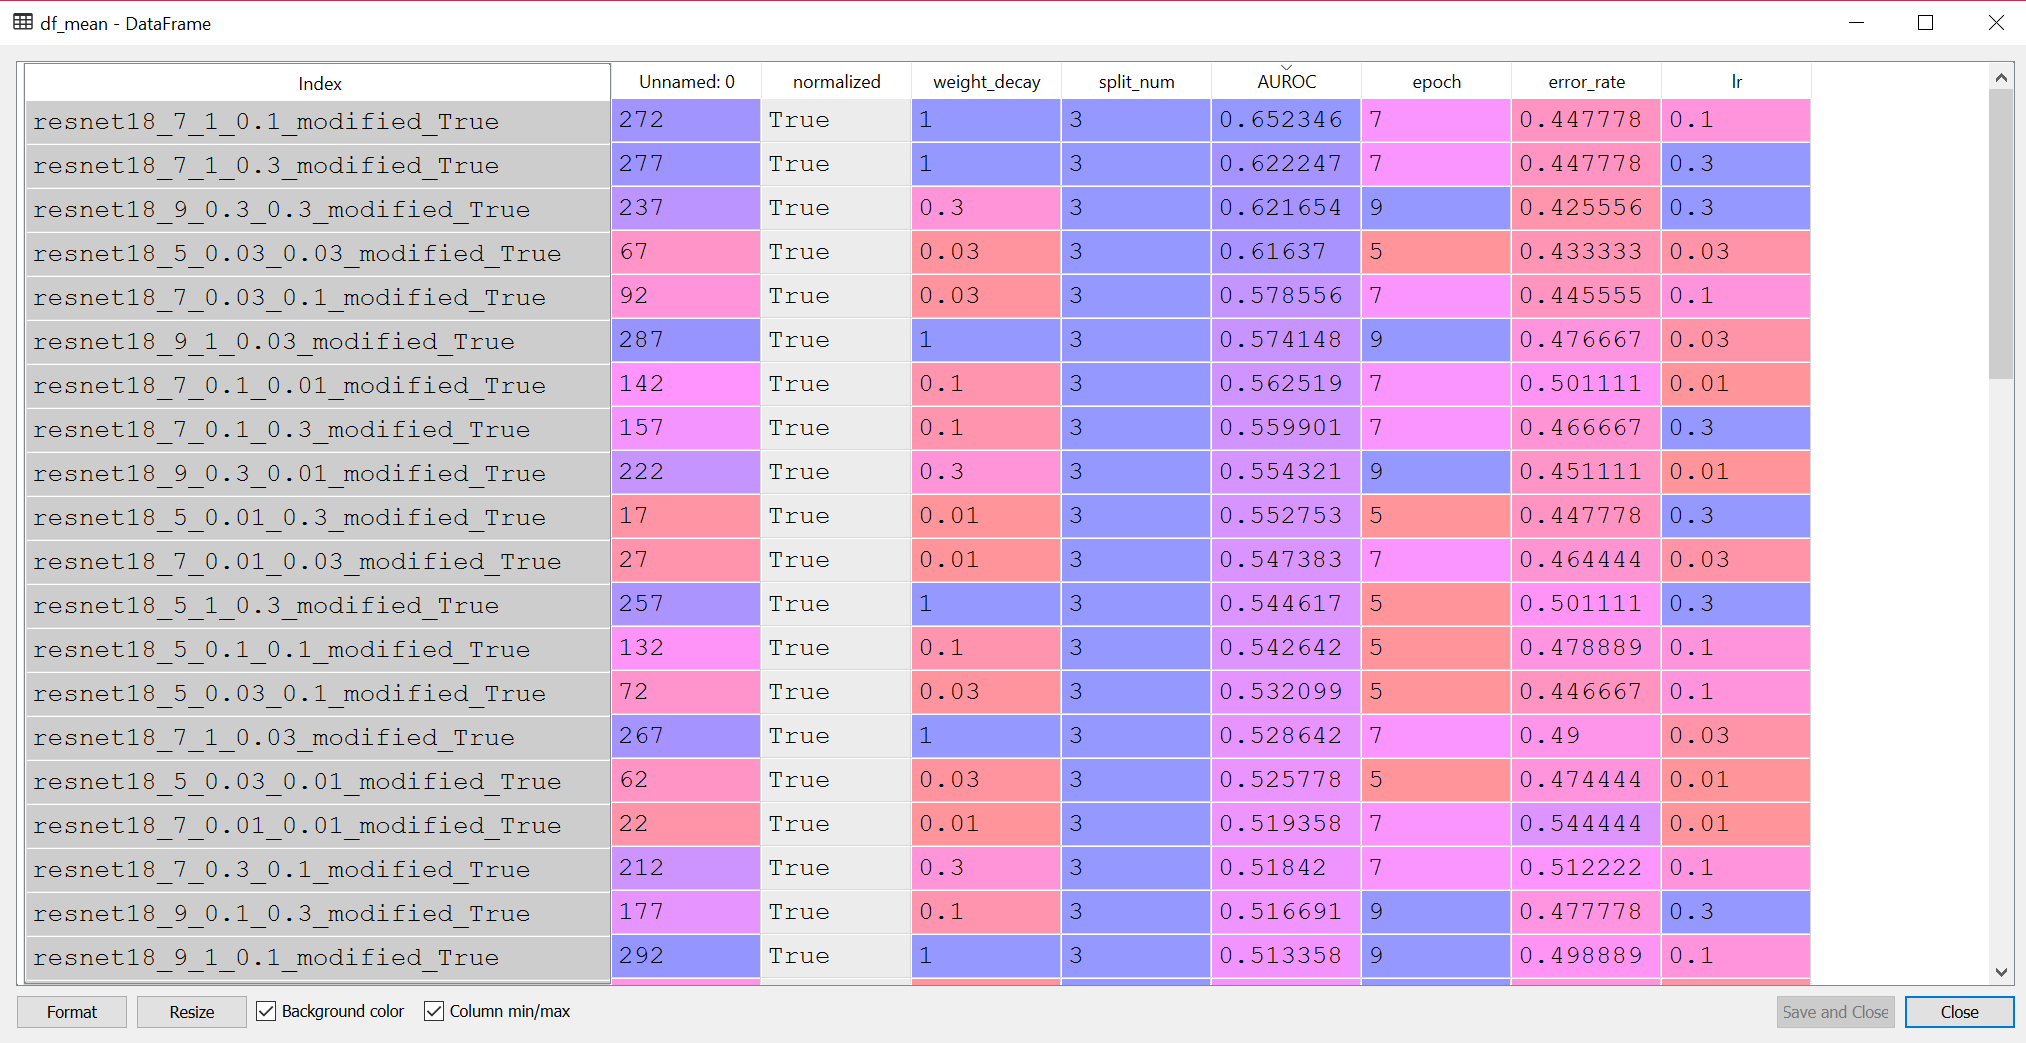

LR vs AUROC at each epoch level
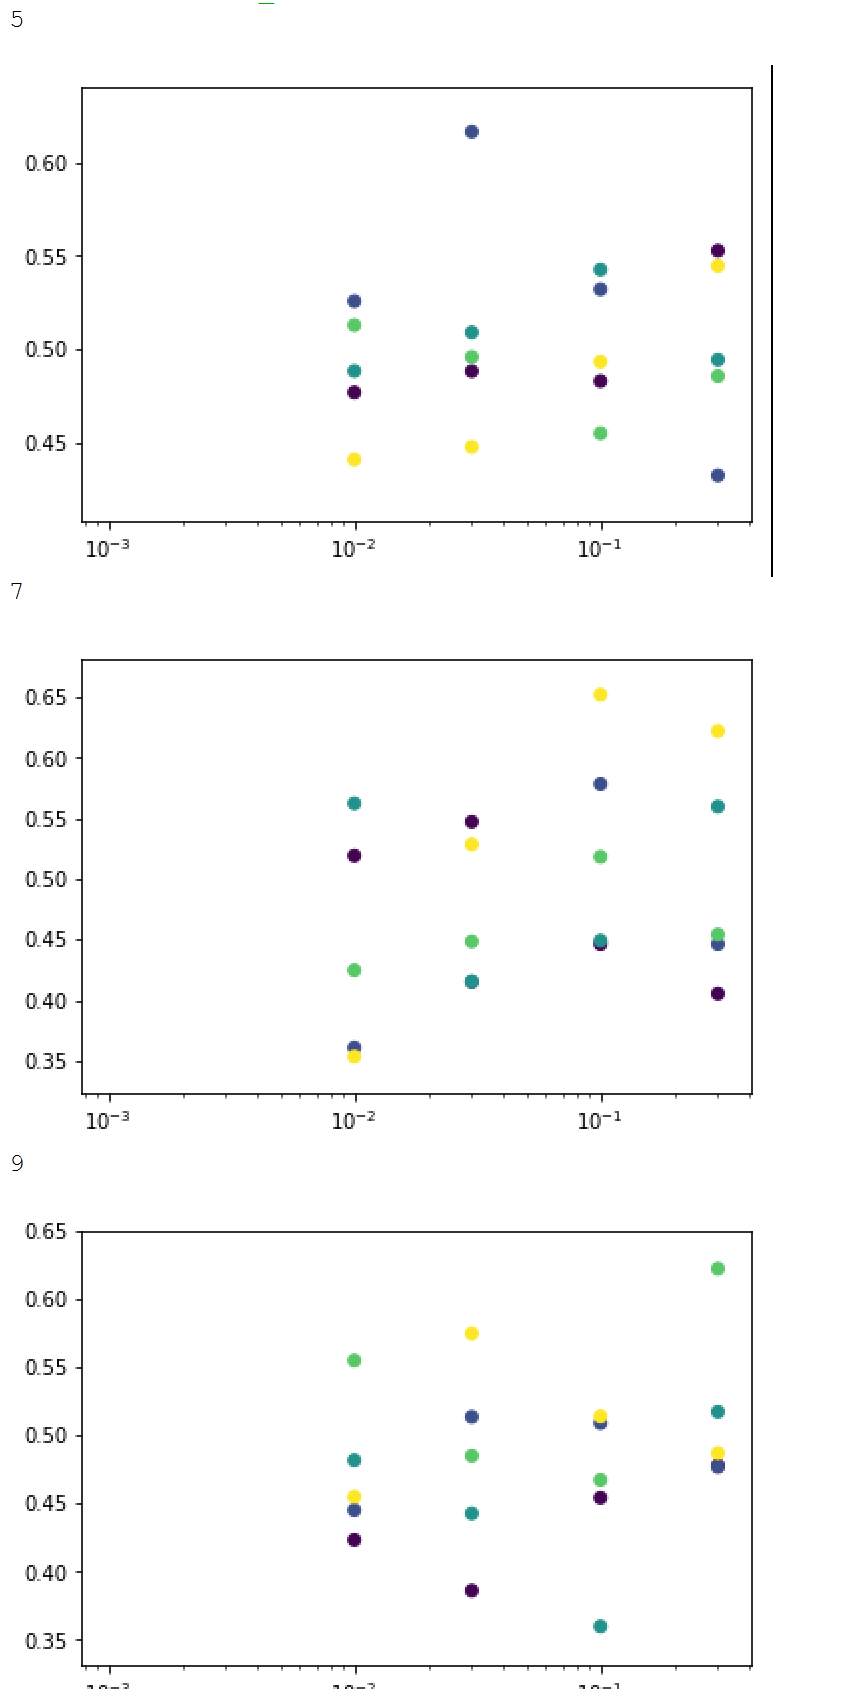

## New hyperparameters Repeated Stratified K Fold


### Test 1
* Resnet18
* 7 Epochs
* learning rate of 0.1
* weight decay of 1
* 5 Fold with 50 repeats

In [5]:
'''
This test resulted in 46.4% of the 250 AUROC scores being >=.5, this was not good enough
The standard deviation of AUROCS was .1308 with a mean of .4885

'''


max_lr = [0.1]
weight_decay = [1]
epoch_cycles = [7]
k=5
repeats = 50

transforms=[[RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
           RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15.0, 15.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
           RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (0.85, 1.15), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.5, resolved={}, do_run=True, is_random=True)],
            []]

# Creating Frame Work
DFBig = pd.DataFrame(columns = ['test_name','model_arch', 'transforms', 'normalized',
                                'weight_decay', 'split_num'])
np.random.seed(42) #locks random seed
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats = 50)
for wd in weight_decay:
    archstr = "resnet18"
    for epochs in epoch_cycles:    
        for lr in max_lr:
            test_name = archstr + '_' + str(epochs) + '_' + str(wd) + '_' + str(lr) + '_' + str('modified') + '_' + str('True')
            print(test_name)
            split_num = 1
            for train_index, val_index in rskf.split(df_Test_Train.index, df_Test_Train['sex']):
                print(str(split_num))
                data_fold = (ImageList.from_df(df_Test_Train,'/home/jplineb/Chicken_Proj')
                             .split_by_idxs(train_index, val_index)
                             .label_from_df(cols='sex')
                             .transform(transforms, size=224)
                             .databunch(bs=2)).normalize()

                learn = cnn_learner(data_fold, models.resnet18, metrics=error_rate,
                                    callback_fns = [CSVLogger,AUROC, partial(EarlyStoppingCallback, monitor='AUROC', mode='max', min_delta=0.01, patience=100)], wd=wd)
                learn.fit_one_cycle(epochs, max_lr=lr)

                df_history = pd.read_csv('history.csv') # adds to dataframec created earlier (again norm and tsfms locked to ON)
                DFBig = DFBig.append({'test_name': test_name,
                                    'model_arch': 'resnet18',
                                    'transforms': 'modified',
                                    'normalized': 'true',
                                    'weight_decay': wd,
                                    'lr' :lr,
                                    'epoch': epochs,
                                    'split_num': split_num, # indicates kfold split
                                    'error_rate' : df_history.error_rate[epochs-1],
                                    'AUROC': df_history.AUROC[epochs-1],
                                    'train_df': df_history}, ignore_index = True)

                split_num+=1
                DFBig.to_csv('DF_resnet18_7_1_0.1_modified_True.csv')

resnet18_7_1_0.1_modified_True
1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


Preview of Results
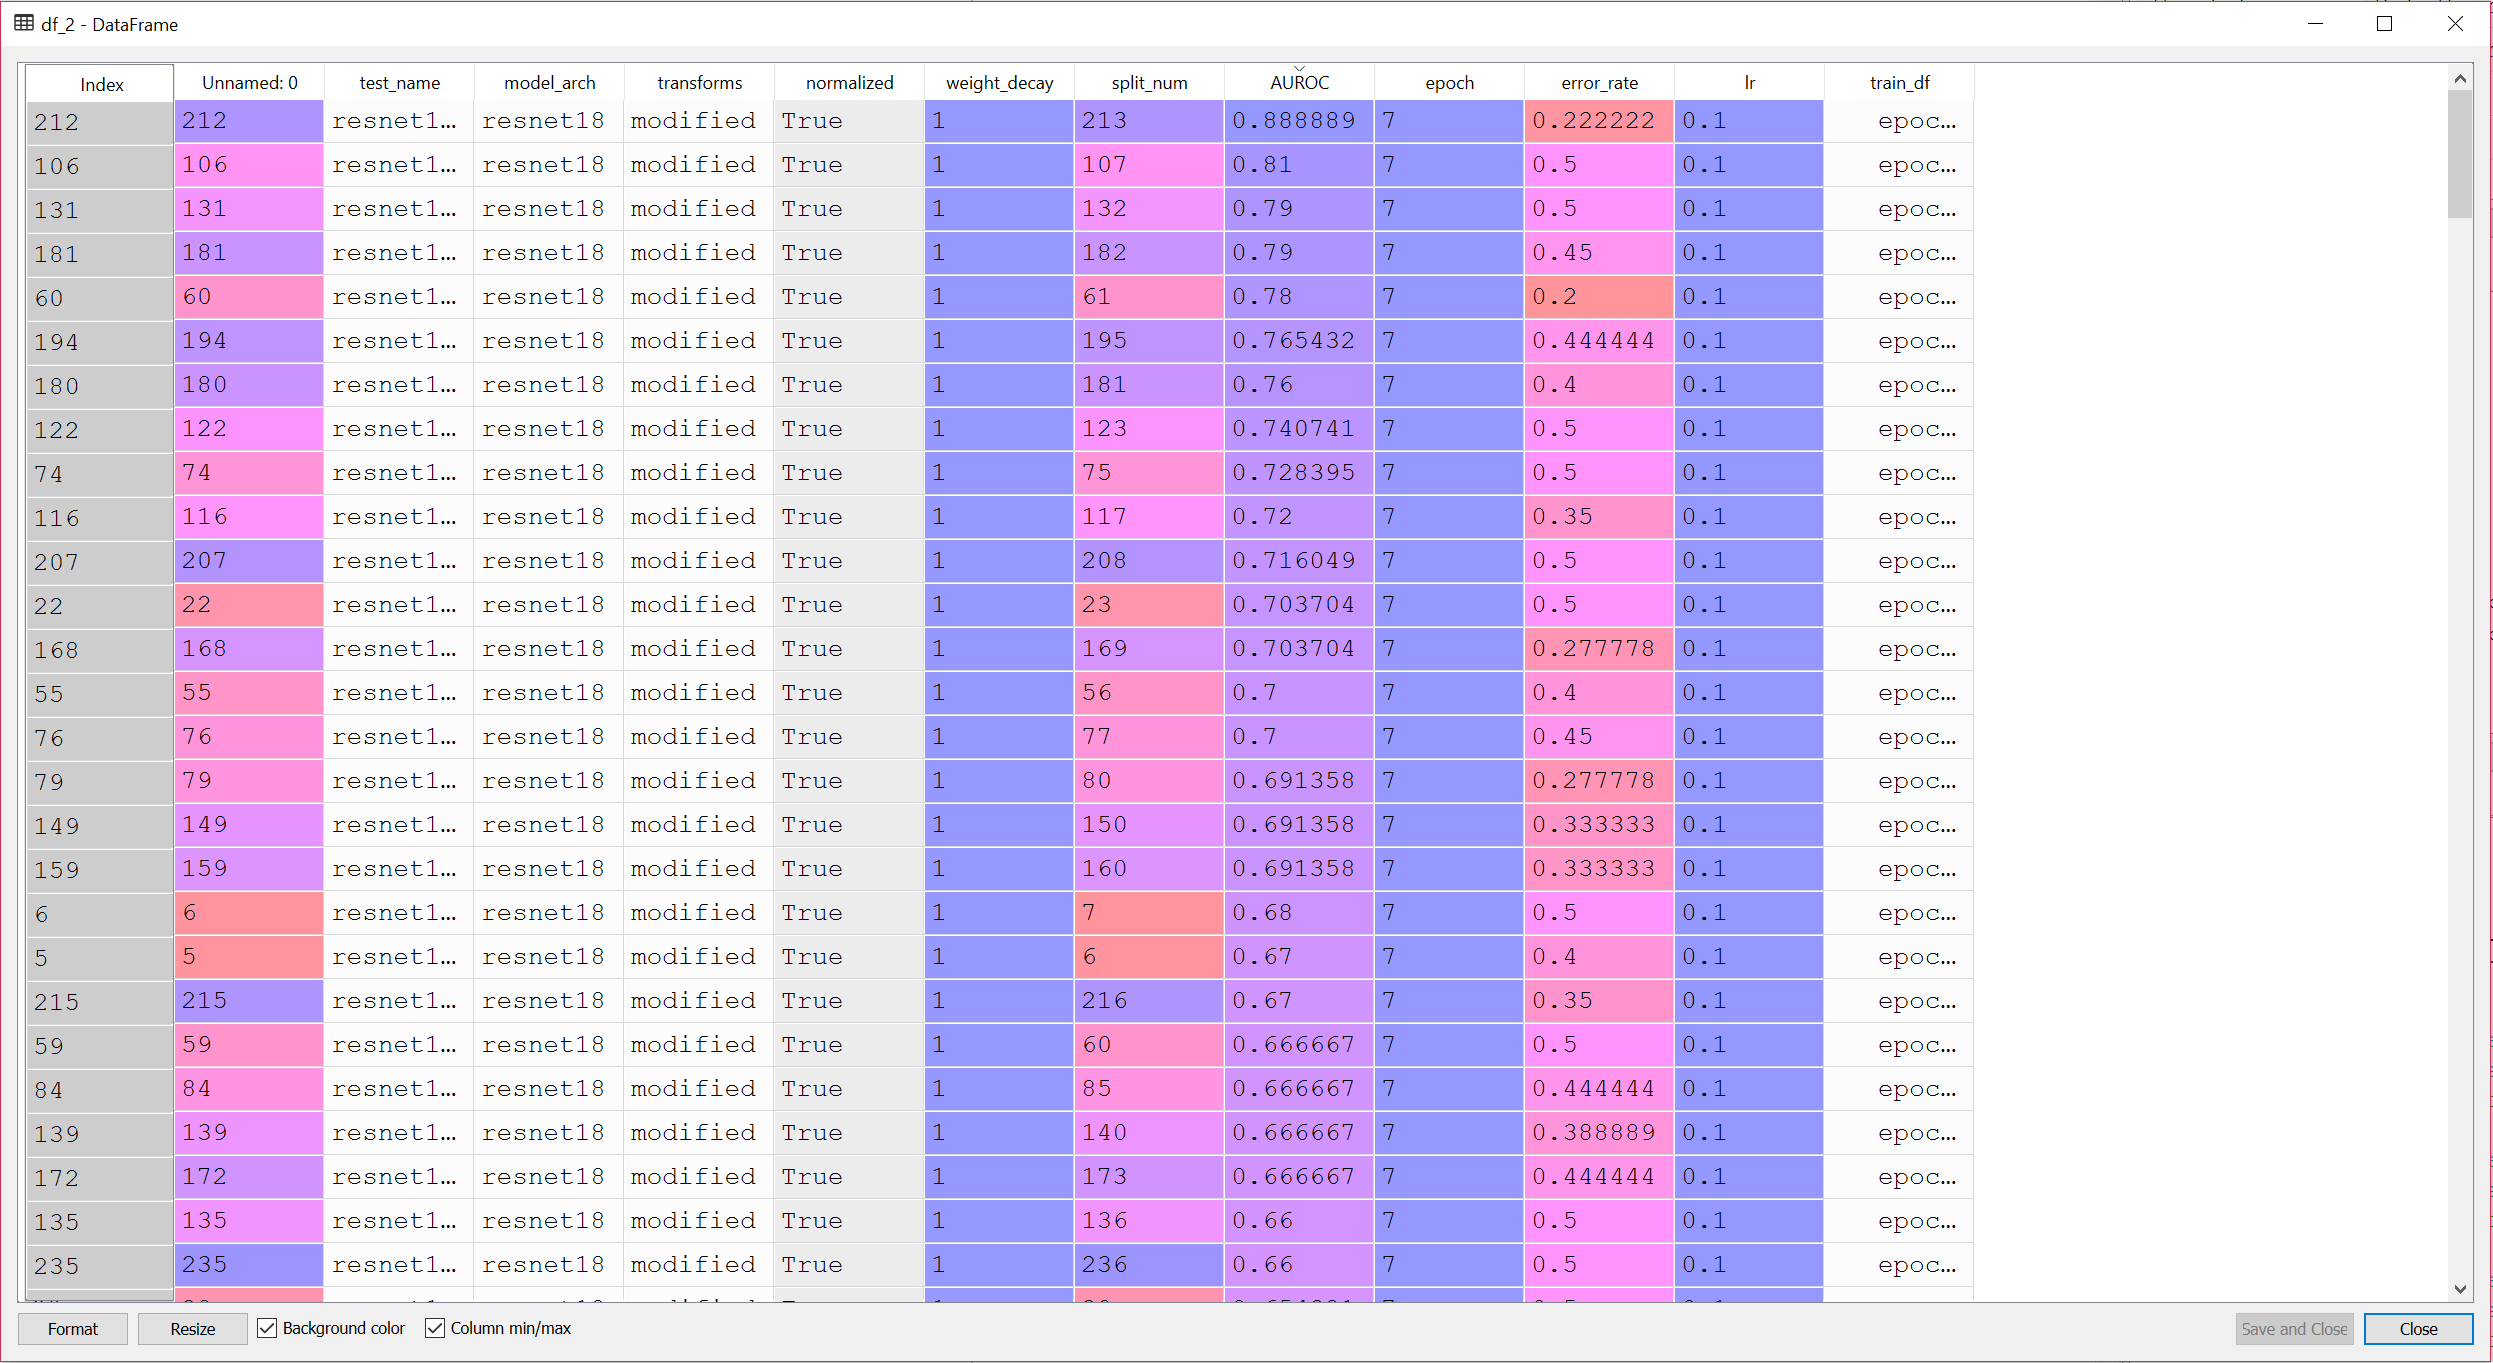

### Test 2
* Resnet18
* 7 Epochs
* weight decay of 1
* learning rate of 0.3
* 5 Fold with 50 repeats

In [4]:
'''
This test resulted in 45.6% of the 250 AUROC scores being >=.5, this was not good enough
The standard deviation of AUROCS was .1354 with a mean of .4776434

'''

max_lr = [0.3]
weight_decay = [1]
epoch_cycles = [7]
k=5
secs_per_epoch=2

transforms=[[RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
           RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-15.0, 15.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
           RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (0.85, 1.15), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.5, resolved={}, do_run=True, is_random=True)],
            []]

# Creating Frame Work
DFBig = pd.DataFrame(columns = ['test_name','model_arch', 'transforms', 'normalized',
                                'weight_decay', 'split_num'])
np.random.seed(42) #locks random seed
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats = 50)
for wd in weight_decay:
    archstr = "resnet18"
    for epochs in epoch_cycles:    
        for lr in max_lr:
            test_name = archstr + '_' + str(epochs) + '_' + str(wd) + '_' + str(lr) + '_' + str('modified') + '_' + str('True')
            print(test_name)
            split_num = 1
            for train_index, val_index in rskf.split(df_Test_Train.index, df_Test_Train['sex']):
                print(str(split_num))
                data_fold = (ImageList.from_df(df_Test_Train,'/home/jplineb/Chicken_Proj')
                             .split_by_idxs(train_index, val_index)
                             .label_from_df(cols='sex')
                             .transform(transforms, size=224)
                             .databunch(bs=2)).normalize()

                learn = cnn_learner(data_fold, models.resnet18, metrics=error_rate,
                                    callback_fns = [CSVLogger,AUROC, partial(EarlyStoppingCallback, monitor='AUROC', mode='max', min_delta=0.01, patience=100)], wd=wd)
                learn.fit_one_cycle(epochs, max_lr=lr)

                df_history = pd.read_csv('history.csv') # adds to dataframec created earlier (again norm and tsfms locked to ON)
                DFBig = DFBig.append({'test_name': test_name,
                                    'model_arch': 'resnet18',
                                    'transforms': 'modified',
                                    'normalized': 'true',
                                    'weight_decay': wd,
                                    'lr' :lr,
                                    'epoch': epochs,
                                    'split_num': split_num, # indicates kfold split
                                    'error_rate' : df_history.error_rate[epochs-1],
                                    'AUROC': df_history.AUROC[epochs-1],
                                    'train_df': df_history}, ignore_index = True)

                split_num+=1
                DFBig.to_csv('DF_resnet18_7_1_0.3_modified_True.csv')

resnet18_7_1_0.3_modified_True
1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


25


26


27


28


29


30


31


32


33


34


35


36


37


38


39


40


41


42


43


44


45


46


47


48


49


50


51


52


53


54


55


56


57


58


59


60


61


62


63


64


65


66


67


68


69


70


71


72


73


74


75


76


77


78


79


80


81


82


83


84


85


86


87


88


89


90


91


92


93


94


95


96


97


98


99


100


101


102


103


104


105


106


107


108


109


110


111


112


113


114


115


116


117


118


119


120


121


122


123


124


125


126


127


128


129


130


131


132


133


134


135


136


137


138


139


140


141


142


143


144


145


146


147


148


149


150


151


152


153


154


155


156


157


158


159


160


161


162


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 484, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 482, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-0xhgt_1o'


163


164


165


166


167


168


169


170


171


172


173


174


175


176


177


178


179


180


181


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 484, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 482, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-lcoahgpi'


182


183


184


185


186


187


188


189


190


191


192


193


194


195


196


197


198


199


200


201


202


203


204


205


206


207


208


209


210


211


212


213


214


215


216


217


218


219


220


221


222


223


224


225


226


227


228


229


230


231


232


233


234


235


236


237


238


239


240


241


242


243


244


245


246


247


248


249


250


Preview of test results
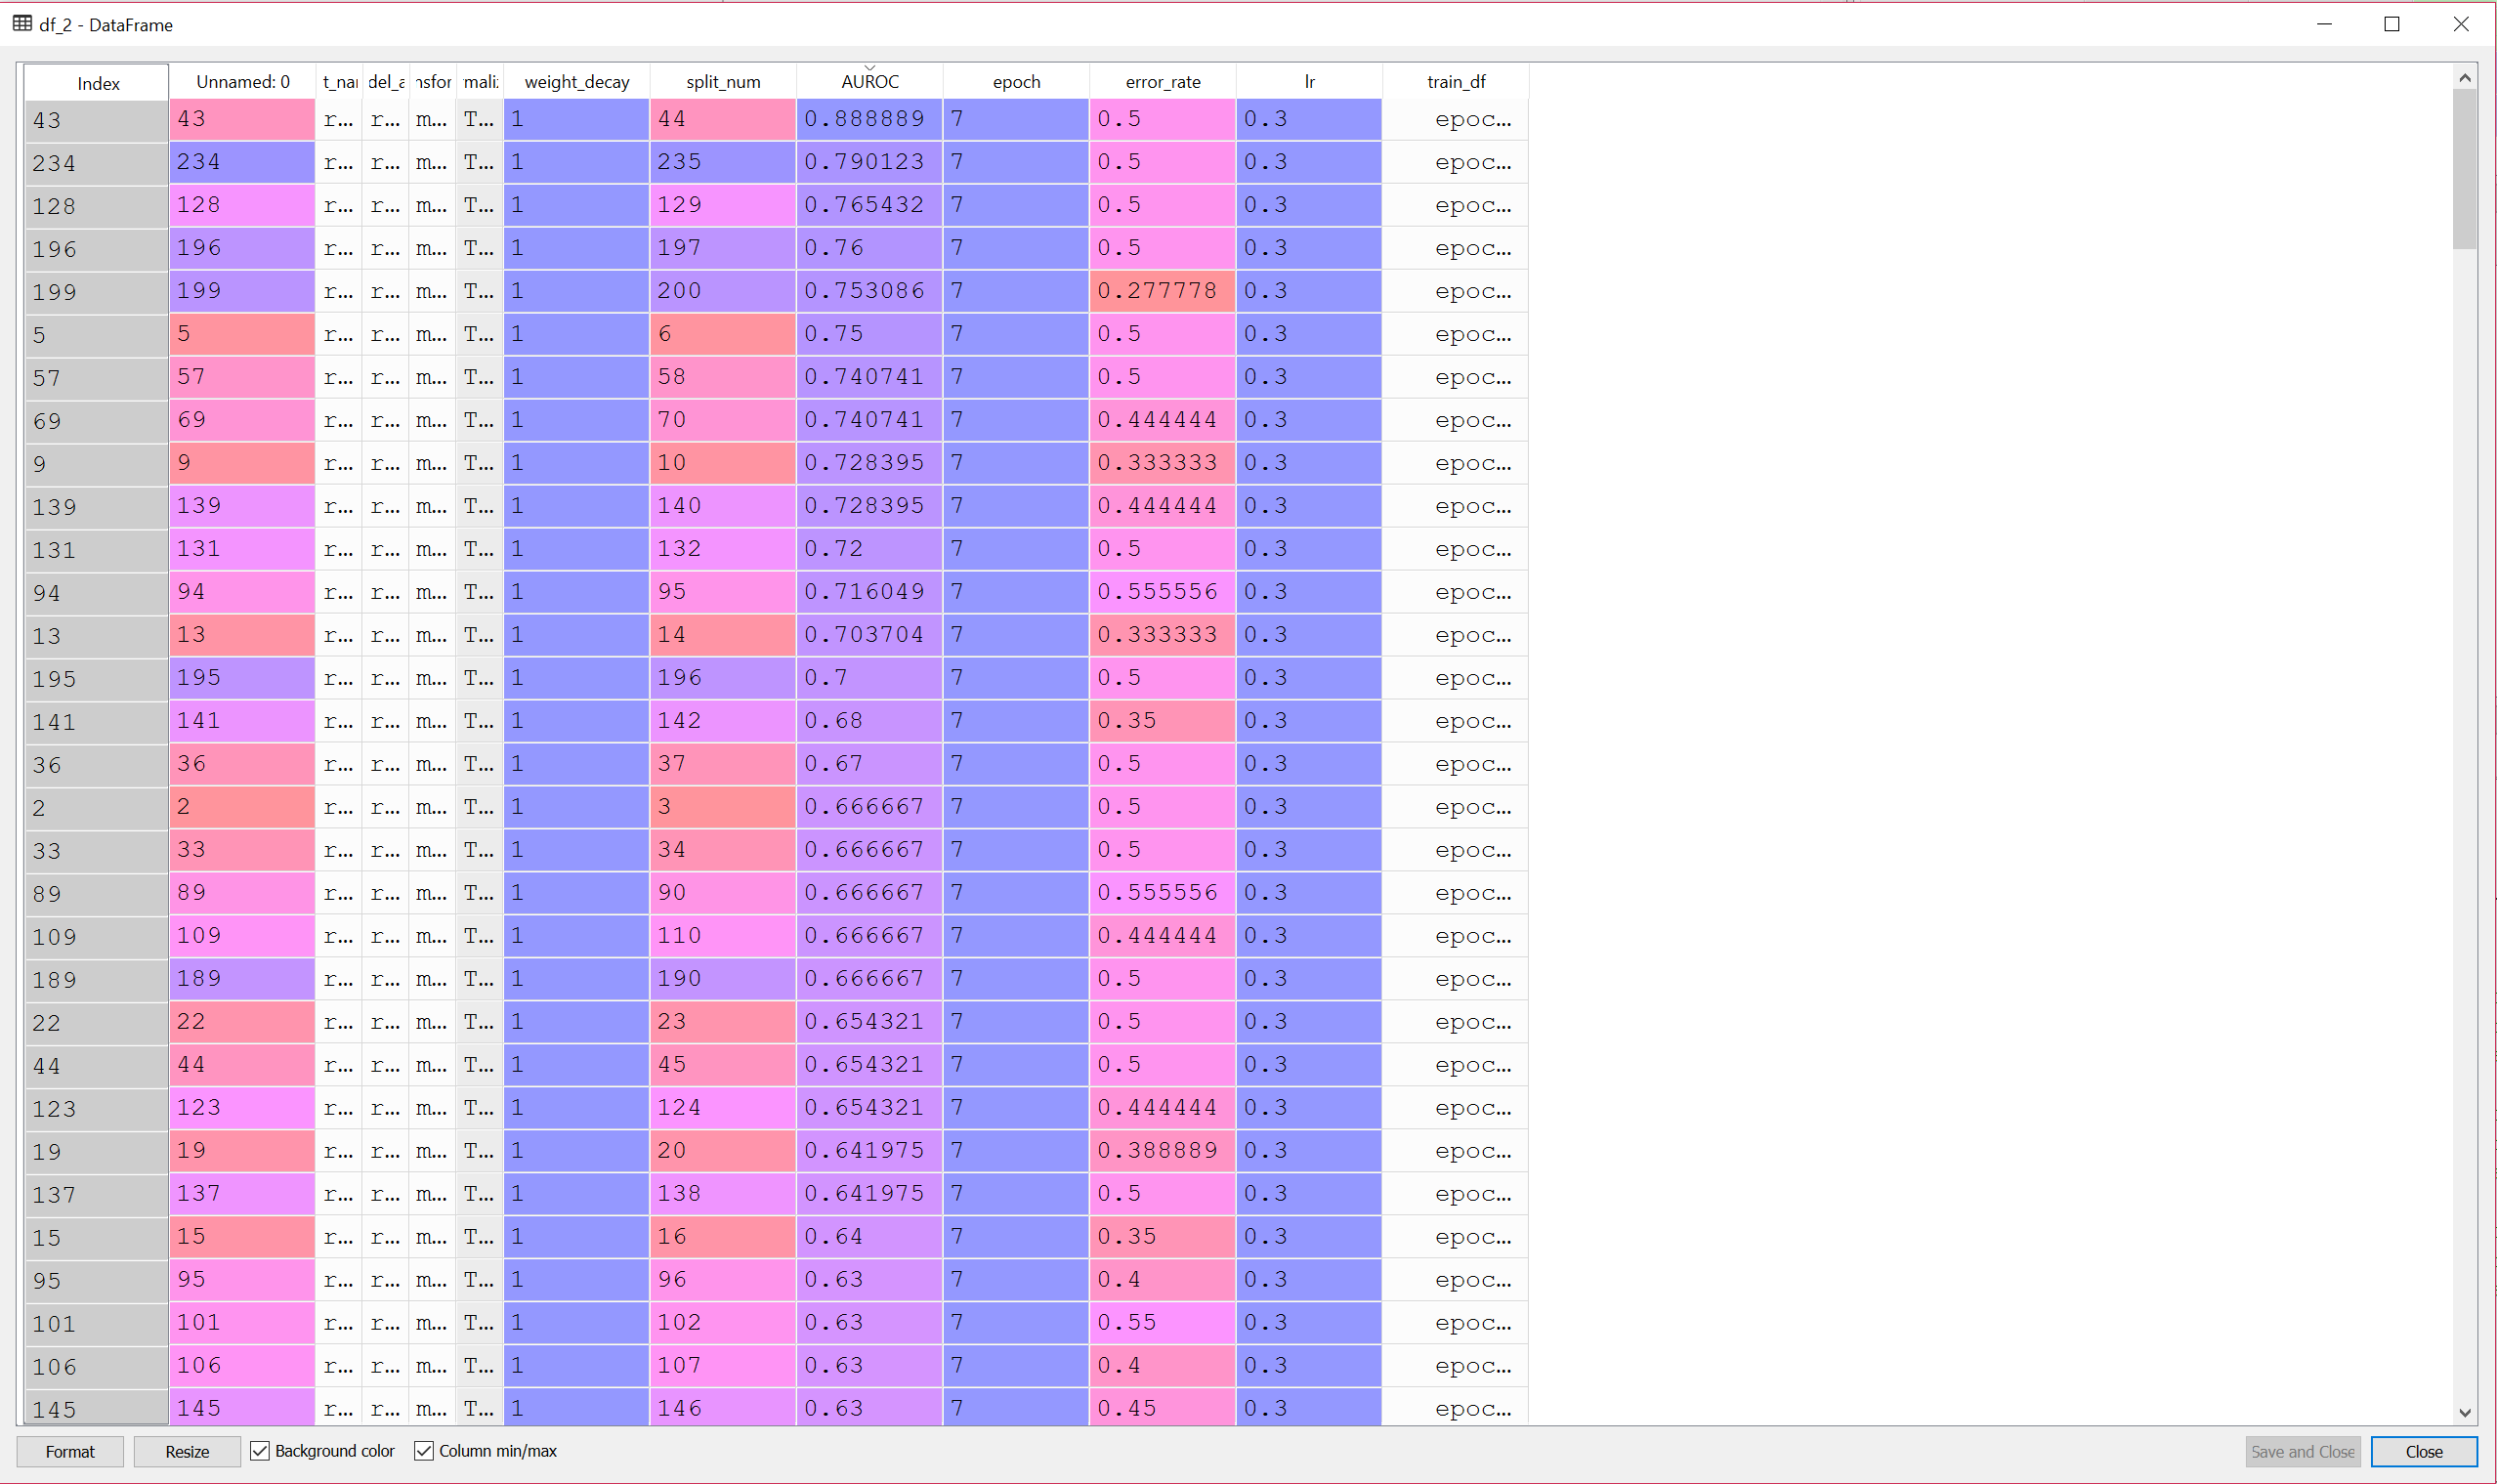